Recurrent Neural Networks (RNNs) are a type of neural network designed to handle sequential data, where the order of elements matters. Unlike traditional neural networks, RNNs have a "memory" that allows them to process information from previous steps in a sequence.

### How RNNs Work (The Core Idea)

Imagine reading a sentence word by word. To understand the current word, you need to remember the words you've already read. RNNs work similarly:

1.  **Sequential Processing:** They process elements of a sequence one by one, step by step.
2.  **Hidden State (Memory):** At each time step $t$, an RNN takes two inputs:
      * The current input element ($x\_t$).
      * The "hidden state" or "memory" from the previous time step ($h\_{t-1}$).
3.  **Current Hidden State:** It then combines these two inputs to compute a new hidden state ($h\_t$). This $h\_t$ essentially summarizes all the information seen so far up to time $t$.
4.  **Output:** From the current hidden state ($h\_t$), it can also produce an output ($y\_t$) for the current time step.
5.  **Parameter Sharing:** Crucially, the *same set of weights* and biases are used across all time steps. This means the network learns a set of rules that apply to any part of the sequence, regardless of its position.

**Mathematical Representation of a Simple RNN Cell:**

At each time step $t$:

  * **Hidden State Update:**
    $h\_t = \\tanh(W\_{xh} x\_t + W\_{hh} h\_{t-1} + b\_h)$

      * $x\_t$: Input at time $t$
      * $h\_{t-1}$: Hidden state from previous time step
      * $W\_{xh}$: Weights connecting input to hidden state
      * $W\_{hh}$: Weights connecting previous hidden state to current hidden state
      * $b\_h$: Bias for the hidden state
      * $\\tanh$: An activation function (e.g., hyperbolic tangent), introduces non-linearity.

  * **Output Calculation (Optional, depends on task):**
    $y\_t = \\text{softmax}(W\_{hy} h\_t + b\_y)$

      * $W\_{hy}$: Weights connecting hidden state to output
      * $b\_y$: Bias for the output
      * $\\text{softmax}$: Used for classification, converts scores into probabilities.

### Example: Character-Level Sequence Prediction

Let's illustrate with a simple example: given a sequence of characters, predict the next character in the sequence. We'll use the word "hello". The RNN will try to learn the pattern:

  * Input 'h' -\> Predict 'e'
  * Input 'e' -\> Predict 'l'
  * Input 'l' -\> Predict 'l'
  * Input 'l' -\> Predict 'o'

Since our RNN is not trained, the predictions will be random, but the process of how they are generated will be clear.


In [5]:
## We'll manually implement the steps of a simple RNN cell using PyTorch's tensor operations to mimic how it works internally.

import torch
import torch.nn.functional as F
import numpy as np

In [1]:
print("--- Understanding the Workings of a Simple RNN ---")

# --- 1. Data Preparation ---
# Define a small vocabulary and map characters to integers and one-hot vectors
vocabulary = ['h', 'e', 'l', 'o', ' '] # ' ' for end of sequence or padding
char_to_ix = {ch: i for i, ch in enumerate(vocabulary)}
ix_to_char = {i: ch for i, ch in enumerate(vocabulary)}

vocab_size = len(vocabulary)
print(f"\nVocabulary: {vocabulary}")
print(f"Character to index mapping: {char_to_ix}")
print(f"Vocabulary Size: {vocab_size}")

# Example sequence: "hello"
# We want to predict: "ello " (where ' ' is the next character after 'o')
input_sequence = [char_to_ix[ch] for ch in "hell"] # Input: h, e, l, l
target_sequence = [char_to_ix[ch] for ch in "ello"] # Target: e, l, l, o (the next character)

sequence_length = len(input_sequence)
print(f"\nInput sequence (indices): {input_sequence} (corresponding to 'hell')")
print(f"Target sequence (indices): {target_sequence} (corresponding to 'ello')")

# Convert integer sequences to one-hot encoded tensors
def to_one_hot(index, size):
    vec = torch.zeros(size)
    vec[index] = 1.0
    return vec

--- Understanding the Workings of a Simple RNN ---

Vocabulary: ['h', 'e', 'l', 'o', ' ']
Character to index mapping: {'h': 0, 'e': 1, 'l': 2, 'o': 3, ' ': 4}
Vocabulary Size: 5

Input sequence (indices): [0, 1, 2, 2] (corresponding to 'hell')
Target sequence (indices): [1, 2, 2, 3] (corresponding to 'ello')


In [6]:
# --- 2. RNN Model Parameters (Untrained - Random Initialization) ---
# Hyperparameters
hidden_size = 5 # Size of the hidden state (our RNN's memory)
output_size = vocab_size # Output size (predicting probabilities for each char in vocab)

# Initialize weights and biases randomly (these would be learned during training)
# W_xh: Weights for input to hidden (vocab_size x hidden_size)
W_xh = torch.randn(vocab_size, hidden_size) * 0.1 # Small random values
# W_hh: Weights for hidden to hidden (hidden_size x hidden_size)
W_hh = torch.randn(hidden_size, hidden_size) * 0.1
# b_h: Bias for hidden (hidden_size)
b_h = torch.randn(hidden_size) * 0.1

# W_hy: Weights for hidden to output (hidden_size x output_size)
W_hy = torch.randn(hidden_size, output_size) * 0.1
# b_y: Bias for output (output_size)
b_y = torch.randn(output_size) * 0.1

print(f"\nRNN Parameters (randomly initialized, not trained):")
print(f"W_xh shape: {W_xh.shape} (Input to Hidden)")
print(f"W_hh shape: {W_hh.shape} (Hidden to Hidden)")
print(f"b_h shape: {b_h.shape} (Hidden Bias)")
print(f"W_hy shape: {W_hy.shape} (Hidden to Output)")
print(f"b_y shape: {b_y.shape} (Output Bias)")


RNN Parameters (randomly initialized, not trained):
W_xh shape: torch.Size([5, 5]) (Input to Hidden)
W_hh shape: torch.Size([5, 5]) (Hidden to Hidden)
b_h shape: torch.Size([5]) (Hidden Bias)
W_hy shape: torch.Size([5, 5]) (Hidden to Output)
b_y shape: torch.Size([5]) (Output Bias)


In [7]:
# --- 3. RNN Step Function (Manual Implementation of One Time Step) ---
def rnn_step(x_t, h_prev, W_xh, W_hh, b_h, W_hy, b_y):
    """
    Performs one step of a simple RNN.
    Args:
        x_t (Tensor): One-hot encoded input at current time t (vocab_size,)
        h_prev (Tensor): Hidden state from previous time step (hidden_size,)
        ... (weights and biases)
    Returns:
        h_t (Tensor): New hidden state at current time t
        y_t (Tensor): Raw output scores at current time t
    """
    # Calculate activation for the hidden state
    # (Input * W_xh) + (Previous Hidden * W_hh) + Bias_h
    h_t_activation = torch.matmul(x_t, W_xh) + torch.matmul(h_prev, W_hh) + b_h
    # Apply tanh activation function
    h_t = torch.tanh(h_t_activation)

    # Calculate activation for the output
    # (Current Hidden * W_hy) + Bias_y
    y_t_activation = torch.matmul(h_t, W_hy) + b_y
    # Note: We return raw scores (logits). Softmax is applied later for probabilities.
    y_t = y_t_activation

    return h_t, y_t

In [8]:
# --- 4. Expanded RNN Process (Unrolling Through Time) ---
# Initialize the initial hidden state (h_0) to zeros
h_t = torch.zeros(hidden_size) # h_0 is all zeros

print("\n--- Expanded RNN Process (Unrolling through the sequence) ---")
print(f"Initial Hidden State (h_0): {h_t.numpy().round(2)}")

outputs = []
for t in range(sequence_length):
    char_idx = input_sequence[t]
    current_char = ix_to_char[char_idx]

    # Get one-hot encoded input for current time step
    x_t = to_one_hot(char_idx, vocab_size)

    print(f"\nTime Step {t+1}: Processing input '{current_char}'")
    print(f"  Input x_{t+1} (one-hot): {x_t.numpy()}")
    print(f"  Previous Hidden State (h_{t}): {h_t.numpy().round(2)}")

    # Perform the RNN step
    h_t, y_t_logits = rnn_step(x_t, h_t, W_xh, W_hh, b_h, W_hy, b_y)

    # Apply Softmax to get probabilities for the output
    y_t_probs = F.softmax(y_t_logits, dim=0)

    # Get the predicted character (highest probability)
    predicted_char_idx = torch.argmax(y_t_probs).item()
    predicted_char = ix_to_char[predicted_char_idx]

    outputs.append(y_t_probs) # Store the probabilities

    print(f"  Calculated Hidden State (h_{t+1}): {h_t.numpy().round(2)}")
    print(f"  Output Logits y_{t+1}: {y_t_logits.numpy().round(2)}")
    print(f"  Output Probabilities y_{t+1} (softmax): {y_t_probs.numpy().round(2)}")
    print(f"  Predicted next character: '{predicted_char}' (Confidence: {y_t_probs.max().item():.2f})")
    # For the next iteration, the current h_t becomes h_prev

print("\n--- Process Complete ---")



--- Expanded RNN Process (Unrolling through the sequence) ---
Initial Hidden State (h_0): [0. 0. 0. 0. 0.]

Time Step 1: Processing input 'h'
  Input x_1 (one-hot): [1. 0. 0. 0. 0.]
  Previous Hidden State (h_0): [0. 0. 0. 0. 0.]
  Calculated Hidden State (h_1): [-0.02  0.2  -0.26  0.09  0.1 ]
  Output Logits y_1: [ 0.05 -0.02  0.21 -0.13 -0.08]
  Output Probabilities y_1 (softmax): [0.21 0.19 0.24 0.17 0.18]
  Predicted next character: 'l' (Confidence: 0.24)

Time Step 2: Processing input 'e'
  Input x_2 (one-hot): [0. 1. 0. 0. 0.]
  Previous Hidden State (h_1): [-0.02  0.2  -0.26  0.09  0.1 ]
  Calculated Hidden State (h_2): [-0.13 -0.09 -0.13  0.17 -0.07]
  Output Logits y_2: [ 0.03 -0.08  0.19 -0.07 -0.09]
  Output Probabilities y_2 (softmax): [0.21 0.18 0.24 0.19 0.18]
  Predicted next character: 'l' (Confidence: 0.24)

Time Step 3: Processing input 'l'
  Input x_3 (one-hot): [0. 0. 1. 0. 0.]
  Previous Hidden State (h_2): [-0.13 -0.09 -0.13  0.17 -0.07]
  Calculated Hidden State

In [9]:
# --- 5. Overall Output Summary ---
print("\nOverall Sequence Prediction (based on random weights):")
predicted_sequence = ""
for t, probs in enumerate(outputs):
    predicted_char_idx = torch.argmax(probs).item()
    predicted_char = ix_to_char[predicted_char_idx]
    predicted_sequence += predicted_char

    input_char = ix_to_char[input_sequence[t]]
    target_char = ix_to_char[target_sequence[t]]
    print(f"Input: '{input_char}' -> Predicted: '{predicted_char}' (Target: '{target_char}')")

print(f"\nFull input processed: 'hell'")
print(f"Full predicted sequence: '{predicted_sequence}'")
print(f"Full target sequence: 'ello'")

print("\n--- Important Note ---")
print("Since the RNN weights (W_xh, W_hh, b_h, W_hy, b_y) are randomly initialized and NOT trained,")
print("the predictions above are essentially random and will likely not match the target sequence.")
print("In a real scenario, these weights would be adjusted through an optimization process (like Gradient Descent via Backpropagation Through Time) to minimize prediction errors.")


Overall Sequence Prediction (based on random weights):
Input: 'h' -> Predicted: 'l' (Target: 'e')
Input: 'e' -> Predicted: 'l' (Target: 'l')
Input: 'l' -> Predicted: 'l' (Target: 'l')
Input: 'l' -> Predicted: 'l' (Target: 'o')

Full input processed: 'hell'
Full predicted sequence: 'llll'
Full target sequence: 'ello'

--- Important Note ---
Since the RNN weights (W_xh, W_hh, b_h, W_hy, b_y) are randomly initialized and NOT trained,
the predictions above are essentially random and will likely not match the target sequence.
In a real scenario, these weights would be adjusted through an optimization process (like Gradient Descent via Backpropagation Through Time) to minimize prediction errors.


### Explanation of the Code and Expanded Process:

1.  **Data Preparation:**

      * We define a small `vocabulary` of characters.
      * `char_to_ix` and `ix_to_char` dictionaries are created for mapping characters to numerical indices and back. This is essential because neural networks work with numbers.
      * The input sequence ("hell") and target sequence ("ello") are converted to numerical indices.
      * `to_one_hot()` function converts an integer index into a one-hot encoded vector. This is how categorical inputs (like characters) are typically fed into neural networks.

2.  **RNN Model Parameters:**

      * We define `hidden_size` (the dimensionality of the hidden state, which controls the RNN's "memory capacity") and `output_size` (which is equal to `vocab_size` for character prediction).
      * The weight matrices (`W_xh`, `W_hh`, `W_hy`) and bias vectors (`b_h`, `b_y`) are initialized with small random numbers. **In a real RNN, these are the parameters that are learned during the training process.**

3.  **`rnn_step` Function (The Core RNN Cell):**

      * This function encapsulates the mathematical operations for a single time step of the RNN.
      * `h_t_activation = torch.matmul(x_t, W_xh) + torch.matmul(h_prev, W_hh) + b_h`: This calculates the weighted sum of the current input (`x_t`) and the previous hidden state (`h_prev`), adding the bias.
      * `h_t = torch.tanh(h_t_activation)`: The hyperbolic tangent (`tanh`) activation function is applied. This squashes the values between -1 and 1 and introduces non-linearity, allowing the RNN to learn complex patterns. This `h_t` is the new hidden state.
      * `y_t_activation = torch.matmul(h_t, W_hy) + b_y`: This calculates the raw scores (logits) for each character in the vocabulary based on the `h_t`.
      * It returns both the new hidden state (`h_t`) and the raw output scores (`y_t_logits`).

4.  **Expanded RNN Process (Unrolling Through Time):**

      * We start with an initial hidden state (`h_t`) of all zeros, representing no prior information.
      * The `for` loop simulates the RNN processing the input sequence character by character (time step by time step).
      * **At each time step `t`:**
          * The current input character (`x_t`) is prepared as a one-hot vector.
          * The `rnn_step` function is called, taking `x_t` and the `h_t` from the *previous* time step as input.
          * The `rnn_step` computes a `new h_t` (which becomes `h_prev` for the *next* time step) and `y_t_logits`.
          * `F.softmax(y_t_logits, dim=0)` converts the raw scores into probabilities for each character, summing to 1.
          * `torch.argmax()` finds the character with the highest probability, which is our RNN's prediction for the next character.
          * Detailed print statements show the input, previous hidden state, calculated hidden state, raw outputs, probabilities, and the predicted character at each step. This gives you a clear "unrolled" view of the RNN's internal flow.

**Important Note on Predictions:**

Because the weights (`W_xh`, `W_hh`, etc.) in this example are **randomly initialized and not trained**, the predicted characters will be random and likely won't form "ello" as intended. In a real-world application, these weights would be learned over many iterations using an optimization algorithm (like Adam or SGD) and a process called **Backpropagation Through Time (BPTT)**, which adjusts the weights to minimize the difference between the RNN's predictions and the actual target sequence.

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training samples: 25000
Testing samples: 25000
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 150ms/step - accuracy: 0.5078 - loss: 0.7064 - val_accuracy: 0.5706 - val_loss: 0.6763
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - accuracy: 0.5664 - loss: 0.6757 - val_accuracy: 0.5994 - val_loss: 0.6568
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 142ms/step - accuracy: 0.6244 - loss: 0.6440 - val_accuracy: 0.6140 - val_loss: 0.6361
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 143ms/step - accuracy: 0.6732 - loss: 0.5994 - val_accuracy: 0.6322 - val_loss: 0.6245
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.7234 - loss: 0.5492 - val_accuracy: 0.6566 - val_loss: 0.6070
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6582 - loss: 0.6105
Test Accuracy: 0.6580
Test Loss: 0.6057


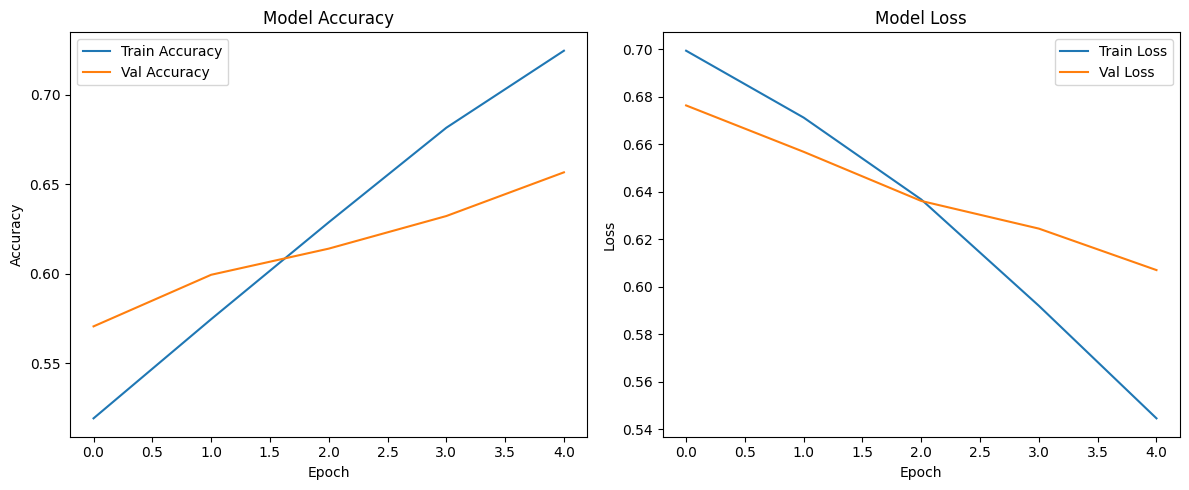

In [10]:
# ===============================
# RNN on IMDb Sentiment Analysis
# ===============================

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# 1. Load IMDb Dataset
num_words = 10000  # use top 10,000 words
maxlen = 200       # each review capped at 200 words

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
print("Training samples:", len(x_train))
print("Testing samples:", len(x_test))

# 2. Pad Sequences (make all reviews equal length)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# 3. Build RNN Model
model = Sequential([
    Embedding(num_words, 128, input_length=maxlen),
    SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

# 4. Compile Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. Train Model
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

# 6. Evaluate on Test Data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# 7. Plot Accuracy and Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
